In [1]:
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), '../core'))
import kaggle_support as kgs
import importlib
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
from dataclasses import dataclass, field, fields
import pack_cuda
import pack_vis
import pack_cost
import copy
import time
from IPython.display import HTML, display, clear_output
pack_cuda.USE_FLOAT32 = True
pack_cuda._ensure_initialized()
import pack_cuda_lut
pack_cuda_lut.USE_TEXTURE = False
pack_cuda_lut._initialized = False  # Force recompile with new code


local
init CUDA
Detected GPU compute capability: 8.9 (arch=sm_89)
GPU max threads per block: 1024
=== Compiling kernel variant: crystal ===
Defines: ENABLE_CRYSTAL_AXES, ENABLE_OVERLAP_AREA, ENABLE_SEPARATION
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_89 -DENABLE_CRYSTAL_AXES -DENABLE_OVERLAP_AREA -DENABLE_SEPARATION -cubin /mnt/d//packing/temp/pack_cuda_saved.cu -o /mnt/d//packing/temp/pack_cuda_crystal.cubin
ptxas info    : 0 bytes gmem, 1172 bytes cmem[3]
ptxas info    : Compiling entry function 'multi_boundary_distance_list_total' for 'sm_89'
ptxas info    : Function properties for multi_boundary_distance_list_total
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 36 registers, used 1 barriers, 404 bytes cmem[0], 16 bytes cmem[2]
ptxas info    : Compile time = 8.837 ms
ptxas info    : Compiling entry function 'multi_boundary_list_total' for 'sm_89'
ptxas info  

In [2]:
N=1000
x_vals = np.linspace(-1., 1., N)
y_vals = np.linspace(-1., 1., N)

xyt = cp.array([[[0.,0.,0.],[x, y, 0.]] for x in x_vals for y in y_vals], dtype=kgs.dtype_cp)
xyt.shape

sol = kgs.SolutionCollectionSquare()
sol.xyt = xyt
sol.h = cp.array([[1.,0.,0.] for _ in range(xyt.shape[0])], dtype=kgs.dtype_cp)
sol.check_constraints()

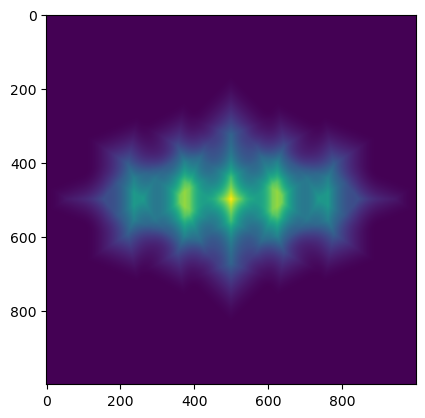

In [3]:
cost1 = pack_cost.CollisionCostSeparation().compute_cost_allocate(sol)[0].get()
cost1 = cost1.reshape((N, N))
plt.imshow(cost1)

Building lookup table for CollisionCostSeparation...
Building LUT: 700 x 700 x 700 = 343,000,000 grid points
  Processing theta 1/700
  Processing theta 51/700
  Processing theta 101/700
  Processing theta 151/700
  Processing theta 201/700
  Processing theta 251/700
  Processing theta 301/700
  Processing theta 351/700
  Processing theta 401/700
  Processing theta 451/700
  Processing theta 501/700
  Processing theta 551/700
  Processing theta 601/700
  Processing theta 651/700
Cost range: [0.000000, 0.302379]
Trimming zero edges:
  X: 700 -> 562 (removed 138)
  Y: 700 -> 652 (removed 48)
  Theta: 700 -> 700 (removed 0)
  Total reduction: 25.2% (86,503,200 points)
Compiling CUDA LUT kernel (USE_TEXTURE=False, one-time only)
Detected GPU compute capability: 89 (arch=sm_89)
Compiling: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -lineinfo -arch=sm_89 -cubin /mnt/d//packing/temp/pack_cuda_lut_saved.cu -o /mnt/d//packing/temp

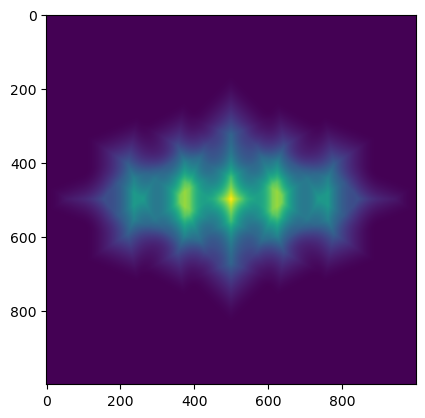

In [4]:
cost_x = pack_cost.CollisionCostSeparation()
cost_x.use_lookup_table = True
cost_x.lut_N_x = 700
cost_x.lut_N_y = 700
cost_x.lut_N_theta = 700
cost2 = cost_x.compute_cost_allocate(sol)[0].get()
cost2 = cost2.reshape((N, N))
plt.imshow(cost2)

<Axes: >

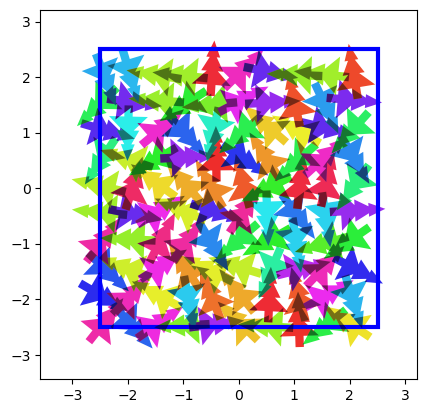

In [5]:
import pack_vis_sol
N_individuals = 1
xy = cp.meshgrid(cp.arange(10), cp.arange(10))
x = (xy[0].ravel()-5)/2
y = (xy[1].ravel()-5)/2
t = cp.random.default_rng(seed=42).uniform(0, 2*np.pi, size=x.shape[0])
xyt = cp.stack([x, y, t], axis=1)
xyt.shape

sol = kgs.SolutionCollectionSquare()
sol.xyt = cp.tile(xyt, (N_individuals, 1, 1))
sol.xyt[:, :, :] += cp.random.default_rng(seed=43).uniform(0, 0.1, size=(N_individuals, sol.N_trees, 3))
sol.h = cp.tile(cp.array([[5.,0.,0.]], dtype=cp.float32), (N_individuals, 1))
sol.xyt = sol.xyt.astype(cp.float32)
sol.h = sol.h.astype(cp.float32)
sol.check_constraints()

pack_vis_sol.pack_vis_sol(sol)

In [6]:
cost_ref = pack_cost.CollisionCostSeparation(scaling=1.)
cost1, grad1, _ = cost_ref.compute_cost_allocate(sol)
cost2, grad2, _ = cost_x.compute_cost_allocate(sol)
cp.max(cp.abs(cost1-cost2)),cp.max(cp.abs(grad1-grad2))


(array(0.00069523, dtype=float32), array(0.08224764, dtype=float32))

Max gradient error (LUT vs FD): 1.755209e-01
Mean gradient error (LUT vs FD): 5.730562e-03


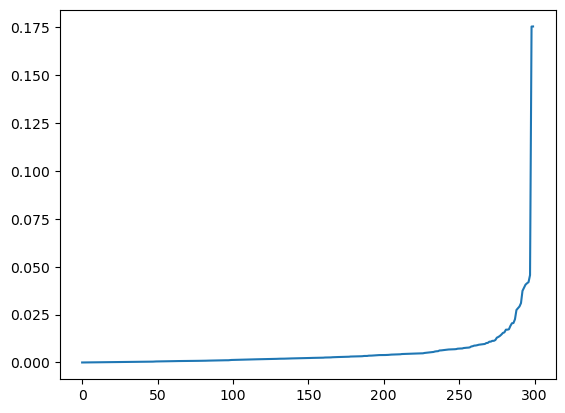

In [7]:
# add a finite difference computation grad2_approx, using eps=1e-3 two-sided
eps = 1e-3
grad2_approx = cp.zeros_like(sol.xyt)

for i in range(sol.N_solutions):
    for j in range(sol.N_trees):
        for k in range(3):  # x, y, theta
            # Perturb +eps
            sol.xyt[i, j, k] += eps
            cost_plus = cost_x.compute_cost_allocate(sol)[0][i]
            
            # Perturb -2*eps (to get to -eps from +eps)
            sol.xyt[i, j, k] -= 2 * eps
            cost_minus = cost_x.compute_cost_allocate(sol)[0][i]
            
            # Restore original value
            sol.xyt[i, j, k] += eps
            
            # Two-sided finite difference
            grad2_approx[i, j, k] = (cost_plus - cost_minus) / (2 * eps)

print(f"Max gradient error (LUT vs FD): {cp.max(cp.abs(grad2 - grad2_approx)).get():.6e}")
print(f"Mean gradient error (LUT vs FD): {cp.mean(cp.abs(grad2 - grad2_approx)).get():.6e}")
plt.figure()
plt.plot(np.sort(np.abs(grad2 - grad2_approx).ravel().get()), label='FD')

In [8]:
# Check if errors are within acceptable bounds for atomicAdd non-determinism
# For float32: machine epsilon ≈ 1.2e-7
# Acceptable error ≈ N_operations × ε × magnitude

cost_err_rel = cp.abs(cost1 - cost2) / (cp.abs(cost1) + 1e-10)
grad_err_rel = cp.abs(grad1 - grad2) / (cp.abs(grad1) + 1e-10)

print("Cost comparison:")
print(f"  Max absolute error: {cp.max(cp.abs(cost1-cost2)).get():.6e}")
print(f"  Max relative error: {cp.max(cost_err_rel).get():.6e}")
print(f"  Mean relative error: {cp.mean(cost_err_rel).get():.6e}")

print("\nGradient comparison:")
print(f"  Max absolute error: {cp.max(cp.abs(grad1-grad2)).get():.6e}")
print(f"  Max relative error: {cp.max(grad_err_rel).get():.6e}")
print(f"  Mean relative error: {cp.mean(grad_err_rel).get():.6e}")

print("\nFloat32 machine epsilon: {:.2e}".format(np.finfo(np.float32).eps))
print(f"Number of tree pairs: {sol.N_trees * (sol.N_trees - 1) // 2}")
print(f"Expected error scale: ~{sol.N_trees * (sol.N_trees - 1) // 2 * np.finfo(np.float32).eps:.2e}")

# Check if errors are reasonable (< 1e-4 relative for float32 with many atomicAdds)
if cp.max(cost_err_rel).get() < 1e-4:
    print("\n✓ Cost errors are within acceptable bounds for atomicAdd non-determinism")
else:
    print("\n✗ Cost errors may indicate a bug (too large for atomicAdd effects alone)")
    
if cp.max(grad_err_rel).get() < 1e-4:
    print("✓ Gradient errors are within acceptable bounds for atomicAdd non-determinism")
else:
    print("✗ Gradient errors may indicate a bug (too large for atomicAdd effects alone)")

Cost comparison:
  Max absolute error: 6.952286e-04
  Max relative error: 1.221811e-04
  Mean relative error: 1.221811e-04

Gradient comparison:
  Max absolute error: 8.224764e-02
  Max relative error: 1.132028e+01
  Mean relative error: 1.426086e-01

Float32 machine epsilon: 1.19e-07
Number of tree pairs: 4950
Expected error scale: ~5.90e-04

✗ Cost errors may indicate a bug (too large for atomicAdd effects alone)
✗ Gradient errors may indicate a bug (too large for atomicAdd effects alone)


In [9]:

cp.mean(cp.abs(cost1-cost2)), cp.mean(cp.abs(grad1-grad2))

(array(0.00069523, dtype=float32), array(0.01028507, dtype=float32))

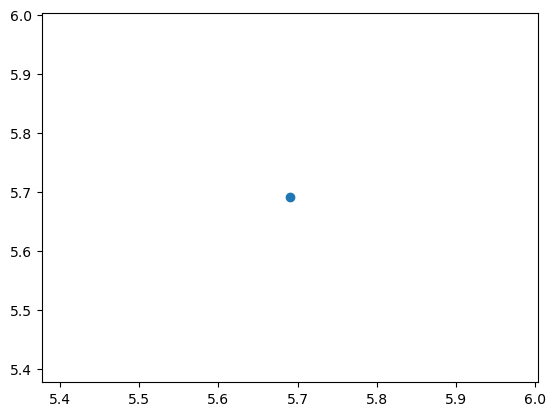

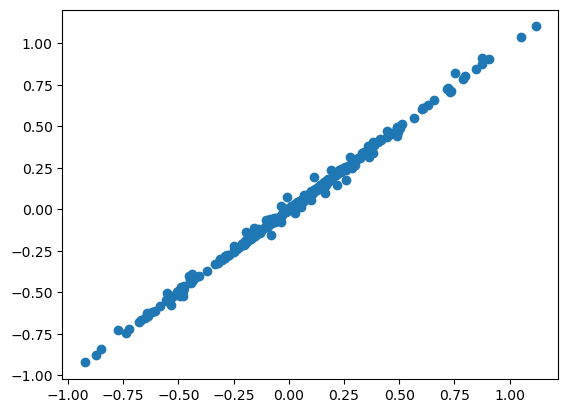

In [10]:
plt.figure()
plt.scatter(cost1.get(), cost2.get())
plt.figure()
plt.scatter(grad1.get(), grad2.get())